# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Overall openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_overall_opensmile_gemaps = pd.read_csv(get_pmemo_path('processed/features/integrated/normalised_essentia_best_overall_opensmile_gemaps_features.csv'))

# drop Unnamed:0 column
df_essentia_best_overall_opensmile_gemaps = df_essentia_best_overall_opensmile_gemaps[df_essentia_best_overall_opensmile_gemaps.columns[1:]]

df_essentia_best_overall_opensmile_gemaps

,song_id,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,1,0.064362,0.214289,0.125964,0.267193,0.482615,0.533418,0.570785,0.423573,0.085510,...,0.655572,0.388723,0.360946,0.477083,0.618233,0.568024,0.012333,0.010856,0.092155,0.066829
1,4,0.345452,0.539877,0.949078,0.304507,0.461919,0.163914,0.158169,0.721330,0.116353,...,0.188228,0.814309,0.194518,0.197515,0.719396,0.075804,0.038816,0.059588,1.000000,1.000000
2,5,0.566046,0.636537,0.525953,0.464434,0.609828,0.714130,0.649047,0.750001,0.098333,...,0.222227,0.754362,0.227733,0.398985,0.719487,0.395234,0.023807,0.022551,0.108542,0.109709
3,6,0.168166,0.426521,0.278434,0.362823,0.392684,0.381464,0.311019,0.736078,0.112022,...,0.519987,0.504598,0.155392,0.542070,0.607535,0.304105,0.005747,0.007682,0.347203,0.335536
4,7,0.050890,0.193447,0.201743,0.445732,0.675341,0.746939,0.781565,0.814618,0.089398,...,0.738294,0.247457,0.612921,0.377957,0.572874,0.442982,0.027635,0.023468,0.038398,0.029670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,0.058467,0.186511,0.184759,0.555560,0.580548,0.612516,0.656733,0.498154,0.419939,...,0.764008,0.249820,0.487869,0.487722,0.471706,0.561126,0.014875,0.047375,0.075363,0.064431
763,996,0.121857,0.234562,0.179638,0.552154,0.660622,0.638703,0.659746,0.145396,0.362563,...,0.744298,0.347816,0.504947,0.673577,0.598725,0.638633,0.009723,0.009633,0.088765,0.082178
764,997,0.046206,0.200557,0.195031,0.144097,0.571115,0.554702,0.580168,0.489563,0.143965,...,0.795206,0.280868,0.446266,0.590639,0.510169,0.532011,0.016340,0.019502,0.080065,0.163099
765,999,0.063658,0.238118,0.238011,0.136955,0.490124,0.476657,0.512086,0.646732,0.018598,...,0.762783,0.304284,0.384011,0.610316,0.377443,0.643245,0.008016,0.018335,0.099848,0.240641


In [4]:
df_essentia_best_overall_opensmile_gemaps.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 100 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   song_id                                         767 non-null    int64  
 1   lowlevel.melbands_kurtosis.mean                 767 non-null    float64
 2   lowlevel.melbands_skewness.mean                 767 non-null    float64
 3   lowlevel.spectral_energy.mean                   767 non-null    float64
 4   tonal.chords_strength.mean                      767 non-null    float64
 5   tonal.hpcp_entropy.mean                         767 non-null    float64
 6   tonal.key_edma.strength                         767 non-null    float64
 7   tonal.key_temperley.strength                    767 non-null    float64
 8   rhythm.beats_loudness_band_ratio.mean_0         767 non-null    float64
 9   rhythm.beats_loudness_band_ratio.mean_1   

Join both the featureset and annotation set together

In [5]:
df_essentia_best_overall_opensmile_gemaps_whole = pd.merge(df_essentia_best_overall_opensmile_gemaps, df_annotations, how='inner', on='song_id')
df_essentia_best_overall_opensmile_gemaps_whole = df_essentia_best_overall_opensmile_gemaps_whole.drop('song_id', axis=1)
df_essentia_best_overall_opensmile_gemaps_whole

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,valence_mean_mapped,arousal_mean_mapped
0,0.064362,0.214289,0.125964,0.267193,0.482615,0.533418,0.570785,0.423573,0.085510,0.291731,...,0.360946,0.477083,0.618233,0.568024,0.012333,0.010856,0.092155,0.066829,0.150,-0.200
1,0.345452,0.539877,0.949078,0.304507,0.461919,0.163914,0.158169,0.721330,0.116353,0.246669,...,0.194518,0.197515,0.719396,0.075804,0.038816,0.059588,1.000000,1.000000,-0.425,-0.475
2,0.566046,0.636537,0.525953,0.464434,0.609828,0.714130,0.649047,0.750001,0.098333,0.116723,...,0.227733,0.398985,0.719487,0.395234,0.023807,0.022551,0.108542,0.109709,-0.600,-0.700
3,0.168166,0.426521,0.278434,0.362823,0.392684,0.381464,0.311019,0.736078,0.112022,0.096844,...,0.155392,0.542070,0.607535,0.304105,0.005747,0.007682,0.347203,0.335536,-0.300,0.025
4,0.050890,0.193447,0.201743,0.445732,0.675341,0.746939,0.781565,0.814618,0.089398,0.102532,...,0.612921,0.377957,0.572874,0.442982,0.027635,0.023468,0.038398,0.029670,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.058467,0.186511,0.184759,0.555560,0.580548,0.612516,0.656733,0.498154,0.419939,0.195246,...,0.487869,0.487722,0.471706,0.561126,0.014875,0.047375,0.075363,0.064431,0.525,0.725
763,0.121857,0.234562,0.179638,0.552154,0.660622,0.638703,0.659746,0.145396,0.362563,0.240145,...,0.504947,0.673577,0.598725,0.638633,0.009723,0.009633,0.088765,0.082178,0.125,0.750
764,0.046206,0.200557,0.195031,0.144097,0.571115,0.554702,0.580168,0.489563,0.143965,0.158980,...,0.446266,0.590639,0.510169,0.532011,0.016340,0.019502,0.080065,0.163099,0.325,0.425
765,0.063658,0.238118,0.238011,0.136955,0.490124,0.476657,0.512086,0.646732,0.018598,0.088106,...,0.384011,0.610316,0.377443,0.643245,0.008016,0.018335,0.099848,0.240641,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_overall_opensmile_gemaps.drop('song_id', axis=1)
features

,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.spectral_energy.mean,tonal.chords_strength.mean,tonal.hpcp_entropy.mean,tonal.key_edma.strength,tonal.key_temperley.strength,rhythm.beats_loudness_band_ratio.mean_0,rhythm.beats_loudness_band_ratio.mean_1,rhythm.beats_loudness_band_ratio.mean_2,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,0.064362,0.214289,0.125964,0.267193,0.482615,0.533418,0.570785,0.423573,0.085510,0.291731,...,0.655572,0.388723,0.360946,0.477083,0.618233,0.568024,0.012333,0.010856,0.092155,0.066829
1,0.345452,0.539877,0.949078,0.304507,0.461919,0.163914,0.158169,0.721330,0.116353,0.246669,...,0.188228,0.814309,0.194518,0.197515,0.719396,0.075804,0.038816,0.059588,1.000000,1.000000
2,0.566046,0.636537,0.525953,0.464434,0.609828,0.714130,0.649047,0.750001,0.098333,0.116723,...,0.222227,0.754362,0.227733,0.398985,0.719487,0.395234,0.023807,0.022551,0.108542,0.109709
3,0.168166,0.426521,0.278434,0.362823,0.392684,0.381464,0.311019,0.736078,0.112022,0.096844,...,0.519987,0.504598,0.155392,0.542070,0.607535,0.304105,0.005747,0.007682,0.347203,0.335536
4,0.050890,0.193447,0.201743,0.445732,0.675341,0.746939,0.781565,0.814618,0.089398,0.102532,...,0.738294,0.247457,0.612921,0.377957,0.572874,0.442982,0.027635,0.023468,0.038398,0.029670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.058467,0.186511,0.184759,0.555560,0.580548,0.612516,0.656733,0.498154,0.419939,0.195246,...,0.764008,0.249820,0.487869,0.487722,0.471706,0.561126,0.014875,0.047375,0.075363,0.064431
763,0.121857,0.234562,0.179638,0.552154,0.660622,0.638703,0.659746,0.145396,0.362563,0.240145,...,0.744298,0.347816,0.504947,0.673577,0.598725,0.638633,0.009723,0.009633,0.088765,0.082178
764,0.046206,0.200557,0.195031,0.144097,0.571115,0.554702,0.580168,0.489563,0.143965,0.158980,...,0.795206,0.280868,0.446266,0.590639,0.510169,0.532011,0.016340,0.019502,0.080065,0.163099
765,0.063658,0.238118,0.238011,0.136955,0.490124,0.476657,0.512086,0.646732,0.018598,0.088106,...,0.762783,0.304284,0.384011,0.610316,0.377443,0.643245,0.008016,0.018335,0.099848,0.240641


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [36]:
num_epochs = 185

Set a random seed to ensure consistent initial weights of the neural network

In [37]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [39]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 99])


Training loop

In [40]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [41]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6760548164683626
Epoch 2, Loss: 0.6735487206614041
Epoch 3, Loss: 0.6710679951922692
Epoch 4, Loss: 0.6686162654458094
Epoch 5, Loss: 0.6661974079924531
Epoch 6, Loss: 0.6638061252938356
Epoch 7, Loss: 0.6614743904107212
Epoch 8, Loss: 0.6591707130103777
Epoch 9, Loss: 0.6569460628772753
Epoch 10, Loss: 0.6547025874545742
Epoch 11, Loss: 0.6524649182019898
Epoch 12, Loss: 0.6502402879326264
Epoch 13, Loss: 0.6480773017275291
Epoch 14, Loss: 0.6459460134549598
Epoch 15, Loss: 0.6438598835317992
Epoch 16, Loss: 0.6417947649558284
Epoch 17, Loss: 0.6397512105831187
Epoch 18, Loss: 0.6377297548395183
Epoch 19, Loss: 0.6357308663621516
Epoch 20, Loss: 0.6337549232728074
Epoch 21, Loss: 0.6318039569101687
Epoch 22, Loss: 0.6298751948879249
Epoch 23, Loss: 0.6279762689805203
Epoch 24, Loss: 0.6261940517294101
Epoch 25, Loss: 0.6247318884844884
Epoch 26, Loss: 0.6232853256784694
Epoch 27, Loss: 0.6218536334943886
Epoch 28, Loss: 0.6204347533242743
Epoch 29, Loss: 0.61903134894

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [42]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 99])


Generating scores

In [43]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [44]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.24231050937417262
Valence RMSE: 0.24780707864781823
Arousal RMSE: 0.23668632761183317
Test R^2 score: tensor([0.3438, 0.5869], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-0.8593, -0.1706], dtype=torch.float64)
Test R^2 score (overall): 0.4653219060479112


In [21]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_overall_opensmile_gemaps_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[0.2238, 0.2874],
        [0.0584, 0.1227],
        [0.4065, 0.5342],
        [0.1897, 0.2444],
        [0.2614, 0.3378],
        [0.0506, 0.1214],
        [0.0509, 0.1214],
        [0.3536, 0.4603],
        [0.0504, 0.1213],
        [0.3538, 0.4606],
        [0.4163, 0.5478],
        [0.0505, 0.1213],
        [0.0504, 0.1213],
        [0.0505, 0.1213],
        [0.1722, 0.2237],
        [0.0505, 0.1213],
        [0.3992, 0.5240],
        [0.0630, 0.1245],
        [0.0507, 0.1214],
        [0.2779, 0.3597],
        [0.2800, 0.3624],
        [0.0592, 0.1228],
        [0.3073, 0.3980],
        [0.0503, 0.1213],
        [0.0506, 0.1214],
        [0.2161, 0.2771],
        [0.3516, 0.4574],
        [0.0504, 0.1213],
        [0.0505, 0.1213],
        [0.3529, 0.4592],
        [0.0502, 0.1213],
        [0.2821, 0.3651],
        [0.2474, 0.3191],
        [0.0841, 0.1335],
        [0.3409, 0.4424],
        [0.4222, 0.5562],
        [0.4219, 0.5557],
        [0.4427, 0.5847],
        [0.2

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.3309, 0.4489], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6760548164683626
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4418226170061021
Valence RMSE: 0.4913034001095547
Arousal RMSE: 0.386051057292986
Test R^2 score: tensor([-1.5794, -0.0991], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-6.3082, -2.1142], dtype=torch.float64)
Test R^2 score (overall): -0.8392498689293058
Num of epochs: 2
Epoch 1, Loss: 0.6760548164683626
Epoch 2, Loss: 0.6735487206614041
Training completed.
Training completed.
Testing model...
Test RMSE: 0.43845269512420687
Valence RMSE: 0.4858514723223685
Arousal RMSE: 0.38526598417917474
Test R^2 score: tensor([-1.5224, -0.0947], dtype=torch.float64)
Test Adjusted R^2 score: tensor([-6.1469, -2.1015], dtype=torch.float64)
Test R^2 score (overall): -0.8085528456290754
Num of epochs: 3
Epoch 1, Loss: 0.6760548164683626
Epoch 2, Loss: 0.6735487206614041
Epoch 3, Loss: 0.6710679951922692
Training completed.
Training completed.
Testing model...
Test RMSE: 0.43

### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

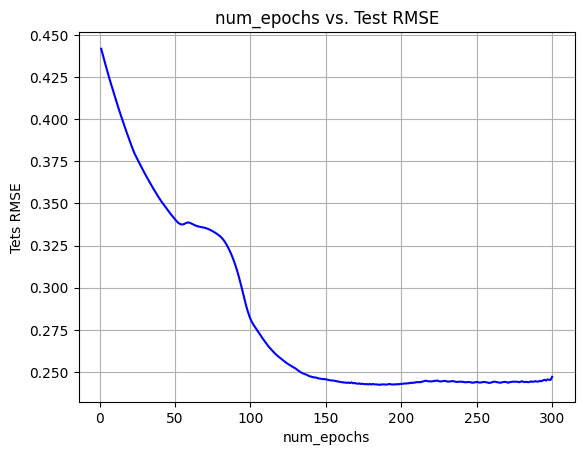

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.24231050937417262
Corresponding R^2 SCore: 0.4653219060479112
Corresponding num_epochs: 185


#### Test R^2 Score vs. num_epochs

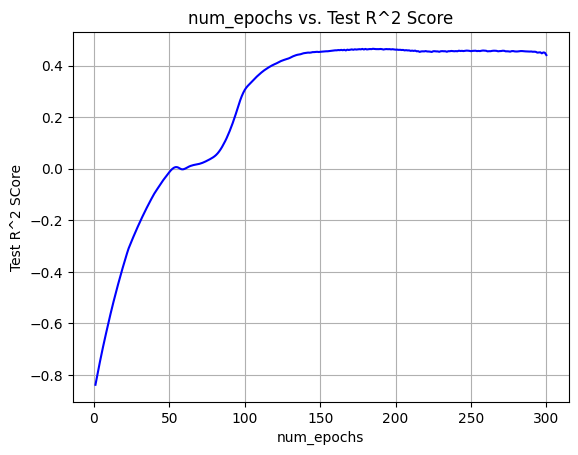

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.4653219060479112
Corresponding RMSE: 0.24231050937417262
Corresponding num_epochs: 185


#### Test Adjsuted R^2 Score (Valence) vs. num_epochs

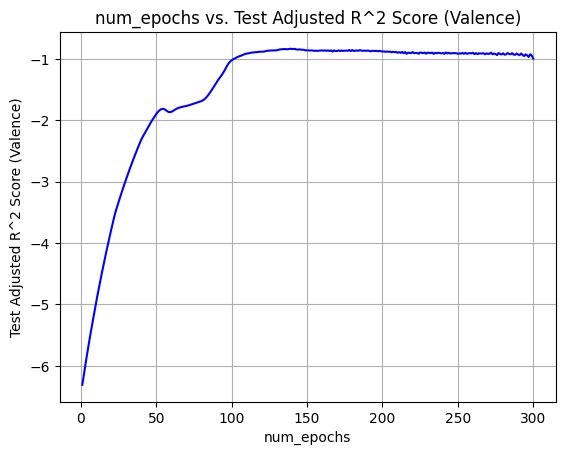

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -0.8378741139503445
Corresponding RMSE: 0.24743233198131015
Corresponding num_epochs: 139


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

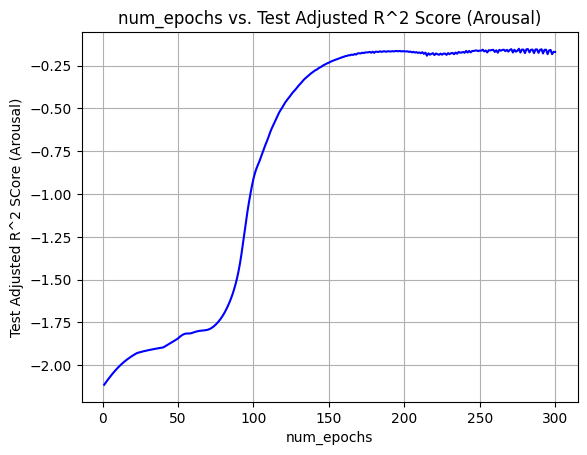

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: -0.1521502598749238
Corresponding RMSE: 0.24416434352864
Corresponding num_epochs: 276
